# <center> Newman on custom trace and user graph </center>

In [33]:
import util
import numpy as np
import networkx as nx
import random as random
from operator import itemgetter
from scipy.special import binom
import matplotlib.pyplot as plt

Load trace.

In [2]:
trace_path = "../Datasets/trace_test.txt"

Get authors.

In [3]:
Author = util.get_authors(trace_path)

Get users.

In [4]:
users = set(Author.values())
print(users)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}


## 1. Initialization

Number of nodes $n$ and list of all node pairs.

In [5]:
n = len(users)
node_pairs = list()
for i in range(n):
    for j in range(n):
        if i != j:
            node_pairs.append((i,j))

Compute E and N. We set the number of observation N to the max of E.

In [93]:
# compute number of edges seen
E = {e:0 for e in node_pairs}
for line in open(trace_path):
    line = line.split()
    uid, rtid = int(line[2]), int(line[3])
    # observe edge if retweet and retweeted user is known
    if rtid != -1 and rtid in Author:
        rtu = Author[rtid]
        if rtu != uid: # no self-edges
            E[rtu, uid] += 1

# set number of observations
N = {e: 2*max(E.values()) for e in node_pairs}

## 2. Iterations

Choose nb of repetitions and max iterations.

In [94]:
repetitions = 100
max_iter = 1000

Proceed.

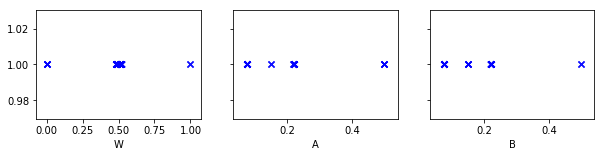

mean value for W : 0.47309543939507864
median value for W : 0.48631145792753105

mean value for A : 0.18300190928375087
median value for A : 0.21950839132856453

mean value for B : 0.16240402517840685
median value for B : 0.14973684210468302



In [103]:
# at each repetition we save the values of w, a and b
results = {'W':list(), 'A':list(), 'B':list()}

for k in range(repetitions):
    
    # we may have divisions by zero
    try:
    
        # random initialization of the parameters
        w = random.random()
        a = random.random()
        b = random.random()

        # iter
        for l in range(max_iter):

            old_w, old_a, old_b = w, a, b

            # compute Qij
            Q = dict()
            for (i,j) in N:
                Q[i,j] = w * a**E[i,j] * (1-a)**(N[i,j]-E[i,j])
                Q[i,j] /= w * a**E[i,j] * (1-a)**(N[i,j]-E[i,j]) + (1-w) * b**E[i,j] * (1-b)**(N[i,j]-E[i,j])

            # update w,a,b
            w = sum(Q.values()) / (n*(n-1))
            numerator_a, numerator_b = 0, 0
            denominator_a, denominator_b = 0, 0
            for (i,j) in N:
                numerator_a += Q[i,j] * E[i,j]
                numerator_b += (1-Q[i,j]) * E[i,j]
                denominator_a += Q[i,j] * N[i,j]
                denominator_b += (1-Q[i,j]) * N[i,j]
            a = numerator_a / denominator_a
            b = numerator_b / denominator_b

            # break if no sufficient evolution
            if np.all(np.abs([a-old_a, b-old_b, w-old_w]) < 0.001):
                break
            
        # add results to results dict
        results['W'].append(w)
        results['A'].append(a)
        results['B'].append(b)
        
    except:
        continue

    
# plot the results and compute mean,med
mean = dict()
med = dict()
plt.rcParams["figure.figsize"] = [10,2]
fig, ax = plt.subplots(1, 3, sharey=True)
for i,(key,values) in enumerate(results.items()):
    values = sorted(values)
    mean[key] = np.mean(values)
    med[key] = np.median(values)
    ax[i].scatter(values, [1]*len(values), marker='x', alpha=.5, color='blue', label=key)
    ax[i].set_xlabel(key)
    
plt.show()
plt.close()

# print most probable
for key in results:
    print("mean value for {} : {}".format(key, mean[key]))
    print("median value for {} : {}".format(key, med[key]))
    print()

## 3. Sample generation

We generate a sample graph according to the posterior distribution.

In [ ]:
G = nx.DiGraph()
G.add_nodes_from(users)

for (i,j) in node_pairs:
    if random.random() < Q[i,j]:
        G.add_edge(i,j)

## 3. Results analysis

Get real graph.

In [11]:
G = nx.DiGraph()
G.add_nodes_from(users)

for line in open("../Datasets/leadgraph_test.txt"):
    line = line.split()
    user = int(line[0])
    for leader in line[1:]:
        leader = int(leader)
        G.add_edge(leader, user)

Compare edges in real graph vs their posterior probability.

Text(0, 0.5, 'nb of actual edges')

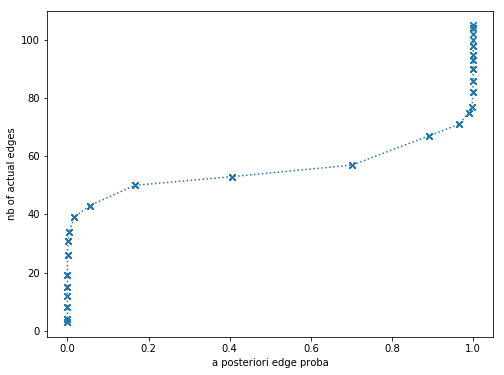

In [132]:
plt.rcParams["figure.figsize"] = [8,6]
real_edges_count = list()
for (e,q) in sorted(Q.items(), key=itemgetter(1)):
    real_edges_count.append(0)
    for e in G.edges:
        if Q[e] <= q:
            real_edges_count[-1] += 1
plt.plot(sorted(Q.values()), real_edges_count, marker='x', ls=':')
plt.xlabel("a posteriori edge proba")
plt.ylabel("nb of actual edges")

Get real value of $\omega,a,b$.

In [45]:
w_real = G.number_of_edges() / (2*binom(n,2))
print("real w = ", w_real)

a_numerator, a_denominator = 0, 0
for e in G.edges:
    a_numerator += E[e]
    a_denominator += N[e]
print("real a = ", a_numerator/a_denominator)

b_numerator, b_denominator = 0, 0
for e in node_pairs:
    if e not in G.edges:
        b_numerator += E[e]
        b_denominator += N[e]
print("real b = ", b_numerator/b_denominator)

real w =  0.27631578947368424
real a =  0.2833862433862434
real b =  0.3056161616161616


Compare expected degrees.

In [107]:
print("Expected degree observed : {} with variance {}".format(2*sum(Q.values())/n, -1))
print("Real expected degree : ", np.mean(G.degree()))

Expected degree observed : 19.542491894406158 with variance -1
Real expected degree :  10.0
